### Difference in Difference Model

In [1]:
import numpy as np
import pandas as pd

pd.set_option("mode.copy_on_write", True)

results = {}

df = pd.read_parquet(
    "https://github.com/qc70duke/IDS-590-final-project/raw/refs/heads/main/df_all_big.parquet"
)

df.info()
df.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 50 columns):
 #   Column                                     Non-Null Count  Dtype          
---  ------                                     --------------  -----          
 0   County Code                                306 non-null    object         
 1   year                                       306 non-null    int64          
 2   overdose_deaths                            298 non-null    float64        
 3   year_group                                 306 non-null    int64          
 4   total_grams                                306 non-null    double[pyarrow]
 5   total_mme                                  306 non-null    double[pyarrow]
 6   GISJOIN                                    306 non-null    object         
 7   STATE                                      306 non-null    object         
 8   COUNTY                                     306 non-null    object         
 9   COUNTYFP  

,County Code,year,overdose_deaths,year_group,total_grams,total_mme,GISJOIN,STATE,COUNTY,COUNTYFP,...,4_or_more_years_of_college,"less_than_10,000","10,000_to_14,999","15,000_to_24,999","25,000_or_more",YEAR,STATEFP,overdose_rate_per_100k,mme_per_capita,avg_population
0,06001,2007,163.0,2009,825601.233034,1052558.500894,G0600010,California,Alameda County,1,...,411652,27989,25930,43910,438331,2009,06,10.903914,0.704111,1515062.0
1,06001,2008,135.0,2009,847083.303522,1117798.930286,G0600010,California,Alameda County,1,...,411652,27989,25930,43910,438331,2009,06,9.030849,0.747754,1515062.0
2,06001,2009,119.0,2009,875071.886798,1199622.098446,G0600010,California,Alameda County,1,...,411652,27989,25930,43910,438331,2009,06,7.960526,0.802489,1515062.0
3,06001,2010,106.0,2011,870211.603741,1247010.639905,G0600010,California,Alameda County,1,...,436208,29125,26168,43635,446143,2011,06,6.904422,0.812254,1515062.0
4,06001,2011,139.0,2011,896433.100448,1296731.400855,G0600010,California,Alameda County,1,...,436208,29125,26168,43635,446143,2011,06,9.053912,0.84464,1515062.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,06085,2012,100.0,2011,409378.978115,737998.111519,G0600850,California,Santa Clara County,85,...,567286,23716,19238,37675,528748,2011,06,5.518130,0.407237,1787481.0
96,06095,2007,27.0,2009,181275.956142,302969.117517,G0600950,California,Solano County,95,...,64987,6341,5043,10012,117916,2009,06,6.559448,0.736041,414439.0
97,06095,2008,32.0,2009,201926.850943,330650.080369,G0600950,California,Solano County,95,...,64987,6341,5043,10012,117916,2009,06,7.774161,0.80329,414439.0
98,06095,2009,31.0,2009,222724.710537,365370.225842,G0600950,California,Solano County,95,...,64987,6341,5043,10012,117916,2009,06,7.531218,0.88764,414439.0


#### Step 1 Create DID Variable (treat / post / years_from_policy)

1. Creat Treat + Control

In [2]:
# control states
control_states = ["California", "New Jersey", "Oregon"]

# treatment + control
df = df[df["STATE"].isin(control_states + ["Florida"])].copy()

# Check
df["STATE"].unique()


# Create the treat variable
df["treat"] = (df["STATE"] == "Florida").astype(int)
df[["STATE", "treat"]].drop_duplicates()

,STATE,treat
0,California,0
126,Florida,1
210,New Jersey,0
282,Oregon,0


2. Create Post Variable

In [3]:
# Create the post variable
df["post"] = (df["year"] >= 2010).astype(int)

# Check
df[["year", "post"]].drop_duplicates().sort_values("year")

,year,post
0,2007,0
1,2008,0
2,2009,0
3,2010,1
4,2011,1
5,2012,1


3. Create years_from_policy

In [4]:
# Create years_from_policy
df["years_from_policy"] = df["year"] - 2010

# Check
df[["year", "years_from_policy"]].drop_duplicates().sort_values("year")

df[["STATE", "year", "treat", "post", "years_from_policy"]].head(20)

,STATE,year,treat,post,years_from_policy
0,California,2007,0,0,-3
1,California,2008,0,0,-2
2,California,2009,0,0,-1
3,California,2010,0,1,0
4,California,2011,0,1,1
5,California,2012,0,1,2
6,California,2007,0,0,-3
7,California,2008,0,0,-2
8,California,2009,0,0,-1
9,California,2010,0,1,0


#### Step 2 Outcomes for DID

1. Log transform outcomes

In [5]:
# log transform outcomes
df["log_mme_pc"] = np.log(df["mme_per_capita"] + 1)
df["log_od_rate"] = np.log(df["overdose_rate_per_100k"] + 1)

df[
    [
        "year",
        "STATE",
        "mme_per_capita",
        "log_mme_pc",
        "overdose_rate_per_100k",
        "log_od_rate",
    ]
].head()

,year,STATE,mme_per_capita,log_mme_pc,overdose_rate_per_100k,log_od_rate
0,2007,California,0.704111,0.533044,10.903914,2.476867
1,2008,California,0.747754,0.558331,9.030849,2.305665
2,2009,California,0.802489,0.589169,7.960526,2.192829
3,2010,California,0.812254,0.594571,6.904422,2.067422
4,2011,California,0.84464,0.612284,9.053912,2.307962


#### Step 3 Pre - Trend

In [6]:
import seaborn.objects as so
import matplotlib.pyplot as plt
import seaborn as sns

1. Grouped for Florida and Controls

In [7]:
# pre-period
pre_df = df[df["year"] < 2010].copy()

# map treat to group names
pre_df["group"] = pre_df["treat"].map({1: "Florida", 0: "Controls"})


def pretrend_plot_so(data, outcome, title, ylabel):

    p = (
        so.Plot(data=data, x="year", y=outcome, color="group")
        # mean line
        .add(so.Line(), so.Est())
        # 95% CI band
        .add(so.Band(), so.Est())
        .label(title=title, x="Year (Pre-Policy)", y=ylabel)
        .layout(size=(7, 5))
    )

    return p

2. Shipments Pre-Trend

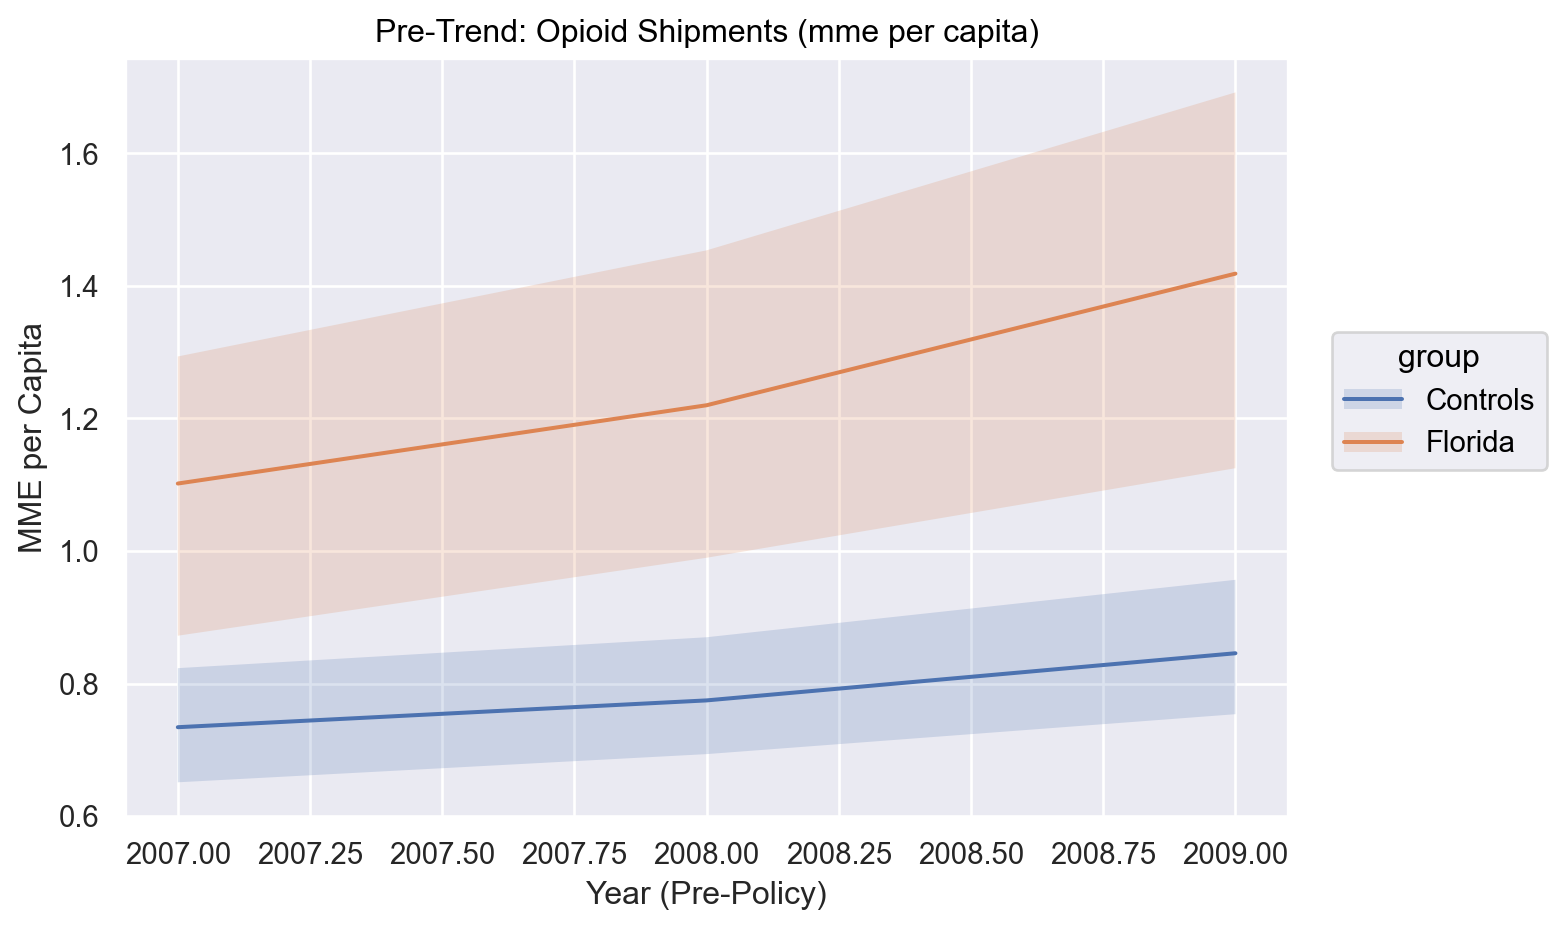

In [8]:
plot_ship = pretrend_plot_so(
    data=pre_df,
    outcome="mme_per_capita",
    title="Pre-Trend: Opioid Shipments (mme per capita)",
    ylabel="MME per Capita",
)

display(plot_ship)

3. Mortality Pre-Trend

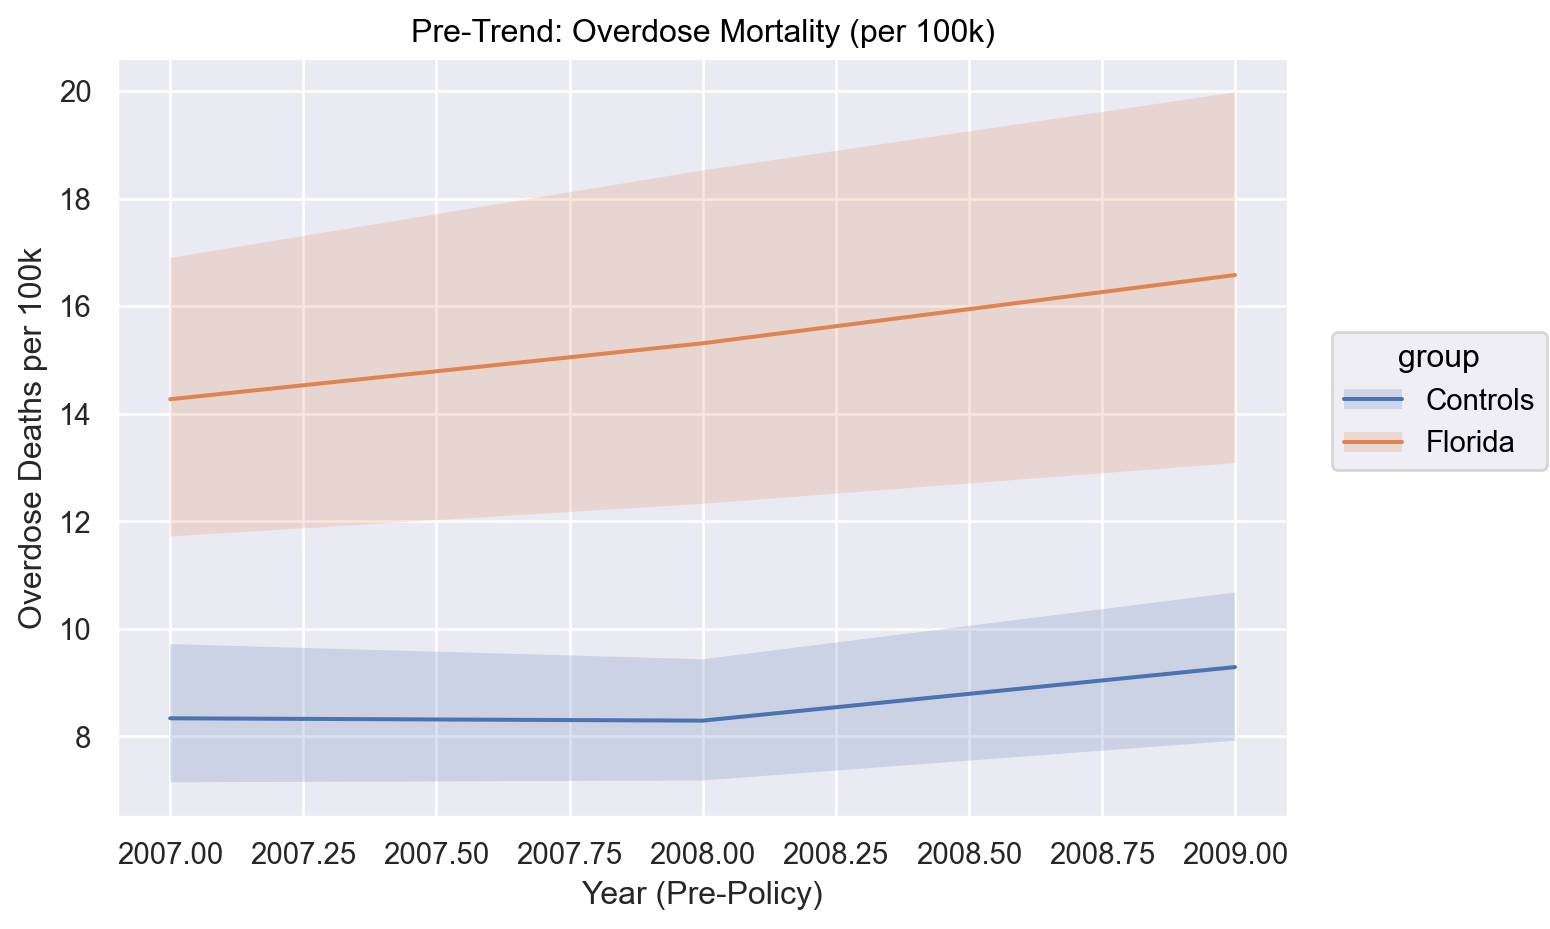

In [9]:
plot_mort = pretrend_plot_so(
    data=pre_df,
    outcome="overdose_rate_per_100k",
    title="Pre-Trend: Overdose Mortality (per 100k)",
    ylabel="Overdose Deaths per 100k",
)
display(plot_mort)

#### Step 4 Pre-Post

1. Florida - only 

In [10]:
fl_df = df[df["treat"] == 1].copy()

2. Pre-Post Function

In [11]:
def prepost_plot_so(data, outcome, title, ylabel):
    y_max = data[outcome].max() / 2

    # create figure and axes
    fig, ax = plt.subplots(figsize=(7, 5))

    p = (
        so.Plot(
            data=data,
            x="years_from_policy",
            y=outcome,
        )
        .add(so.Line(), so.Est())  # mean line
        .add(so.Band(), so.Est())  # CI band
        .label(title=title, x="Years from Policy Change", y=ylabel)
    )
    p.on(ax).plot()

    # add a vertical line at 0
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    # add the mark
    ax.text(0, y_max, "Policy Change", ha="center", va="bottom")

    return fig

3. Shipment Pre-Post

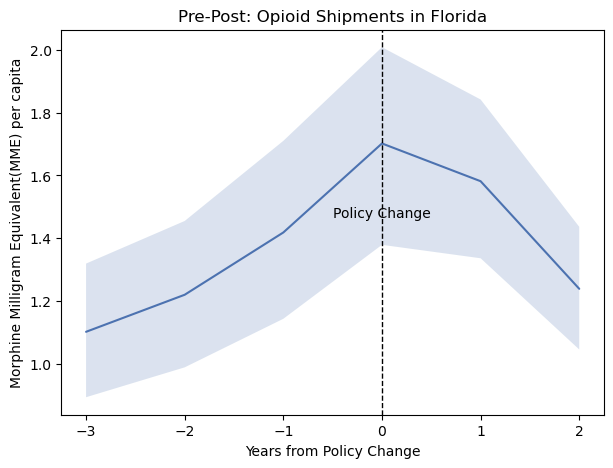

In [12]:
# plot the change of MME per capita over years
plot_pp_ship = prepost_plot_so(
    data=fl_df,
    outcome="mme_per_capita",
    title="Pre-Post: Opioid Shipments in Florida",
    ylabel="Morphine Milligram Equivalent(MME) per capita",
)

4. Mortality Pre-Post

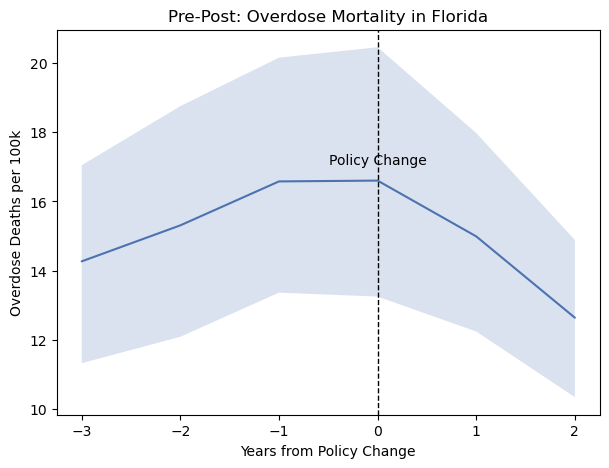

In [13]:
# # plot the change of overdose mortality over years
plot_pp_mort = prepost_plot_so(
    data=fl_df,
    outcome="overdose_rate_per_100k",
    title="Pre-Post: Overdose Mortality in Florida",
    ylabel="Overdose Deaths per 100k",
)

#### Interpretation of pre-post analysis
The two major outcome variables are Morphine Milligram Equivalent (MME) per capita and Overdose Deaths per 100,000 persons. Before the implementation of opioid policy, from 2007 to 2010, there was a steady increase in opioid shipments in Florida in Figure 3, with a continued increasing rate over three years. However, after the policy took place, there was a noticeable decrease in the MME per capita from 2010 to 2012. The trend of opioid shipments shows a steepening decline, suggesting that the policies were more effective in the second year. Using a 95% confidence level, the width of the confidence intervals is within a normal range, suggesting a relatively certain measurement.  

In Figure 4, for overdose mortality in Florida, there was a slight increase in the number of overdose deaths from 2007 to 2009. There was virtually no change from 2009 to 2010. However, after the implementation of opioid control policies, the amount of overdose mortality exhibited a significant decrease with an accelerating rate, suggesting that the policies were effective. However, the width of confidence intervals is relatively large, especially in the pre-policy period, meaning that there is a high uncertainty in the estimates.  

However, it should be noted that the pre-post analysis has its limitations. The lack of treatment groups weakens its reliability. The findings in pre-post analysis cannot rule out other concurrent possibilities, making it less convincing to people. To further address the problems, we adopt Difference-in-Difference analysis to find the causal relationships. 



#### Step 5
Difference-in-Differences

1. Create Group Name

In [14]:
did_df = df.copy()
did_df["group"] = did_df["treat"].map({1: "Florida", 0: "Comparison States"})

2. DID plot

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.objects as so
import statsmodels.formula.api as smf


def compute_mean_ci(df, outcome):

    summary = (
        df.groupby("years_from_policy")[outcome]
        .agg(["mean", "count", "std"])
        .reset_index()
    )

    summary["se"] = summary["std"] / summary["count"] ** 0.5
    summary["ci_low"] = summary["mean"] - 1.96 * summary["se"]
    summary["ci_high"] = summary["mean"] + 1.96 * summary["se"]

    return summary


def compute_regression_adjusted_means(df, outcome):

    # drop na values
    df2 = df.dropna(
        subset=[outcome, "treat", "post", "COUNTYFP", "year", "years_from_policy"]
    ).copy()

    # DID：outcome ~ treat*post + county FE + year FE
    model = smf.ols(
        f"{outcome} ~ C(COUNTYFP) + C(year) + C(years_from_policy)*treat", data=df2
    ).fit()

    # 2. using models to estimate yhat
    df2["yhat"] = model.predict(df2)

    # 3. using yhat to compute means and CIs by group × years_from_policy
    summary = (
        df2.groupby(["group", "years_from_policy"])["yhat"]
        .agg(["mean", "count", "std"])
        .reset_index()
    )

    summary["se"] = summary["std"] / np.sqrt(summary["count"])
    summary["ci_low"] = summary["mean"] - 1.96 * summary["se"]
    summary["ci_high"] = summary["mean"] + 1.96 * summary["se"]

    return summary

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def did_plot_great(df, outcome, title, ylabel):

    # using DID estimate to compute regression-adjusted means
    adj = compute_regression_adjusted_means(df, outcome)

    f = adj[adj["group"] == "Florida"]
    c = adj[adj["group"] == "Comparison States"]

    # -----------------------------
    #   HIGH DPI + RETINA CLEAN
    # -----------------------------
    %config InlineBackend.figure_format = 'retina'
    SIZE = 18

    plt.rcParams["figure.autolayout"] = False
    plt.rcParams["figure.figsize"] = (10, 6)
    %matplotlib inline
    plt.rcParams["figure.dpi"] = 120     # interaction
    plt.rcParams["savefig.dpi"] = 300    # export
    plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = SIZE
    plt.rcParams["axes.titlesize"] = SIZE
    plt.rcParams["axes.labelsize"] = SIZE
    plt.rcParams["xtick.labelsize"] = SIZE - 2
    plt.rcParams["ytick.labelsize"] = SIZE - 2

    fig, ax = plt.subplots(figsize=(10,6))

    # -----------------------------
    #      PLOT CI + MEAN
    # -----------------------------
    # Controls
    ax.fill_between(
        c["years_from_policy"], c["ci_low"], c["ci_high"],
        color="#2B2F42", alpha=0.15
    )
    ax.plot(
        c["years_from_policy"], c["mean"],
        color="#2B2F42", linewidth=3
    )

    # Florida
    ax.fill_between(
        f["years_from_policy"], f["ci_low"], f["ci_high"],
        color="#EF233C", alpha=0.15
    )
    ax.plot(
        f["years_from_policy"], f["mean"],
        color="#EF233C", linewidth=3
    )

    # -----------------------------
    #        INLINE LABELS
    # -----------------------------
    ax.text(
        f["years_from_policy"].iloc[-1] + 0.05,
        f["mean"].iloc[-1],
        "Florida",
        color="#EF233C", fontsize=SIZE, fontweight="bold"
    )
    ax.text(
        c["years_from_policy"].iloc[-1] + 0.05,
        c["mean"].iloc[-1],
        "Comparison States",
        color="#2B2F42", fontsize=SIZE, fontweight="bold"
    )

    # -----------------------------
    #       POLICY VERTICAL LINE
    # -----------------------------
    ax.axvline(0, color="black", linestyle="--", linewidth=1.5)

    # -----------------------------
    #         CLEAN STYLE
    # -----------------------------
    ax.grid(False)                        
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)  

    # Only keep short ticks
    ax.tick_params(axis="y", length=4)
    ax.tick_params(axis="x", length=4)

    # Remove the space by bounding bottom axis
    xmin = df["years_from_policy"].min()
    xmax = df["years_from_policy"].max()
    ax.spines["bottom"].set_bounds(xmin, xmax)

    # -----------------------------
    #       TITLES + LABELS
    # -----------------------------
    ax.set_title(title, pad=20)
    ax.set_xlabel("Years from Policy Change")
    ax.set_ylabel(ylabel)

    # -----------------------------
    #         ADD NOTATION
    # -----------------------------
    ax.text(
        0.5, -0.18, 
       "Note: This figure plots regression-adjusted predictions from a DID model\n"
       "with county and year fixed effects. \n"
       "Formal inference uses the same specification as in Table 1.",
       fontsize=SIZE - 4,
       ha='center',
       va='top',
       transform=ax.transAxes
   )

    plt.tight_layout()
    return fig, ax

3. DID – Shipments（mme_per_capita）

(<Figure size 1200x720 with 1 Axes>,
 <Axes: title={'center': 'Figure1: Difference-in-Differences: Opioid Shipments'}, xlabel='Years from Policy Change', ylabel='Morphine Milligram Equivalents per 1000'>)

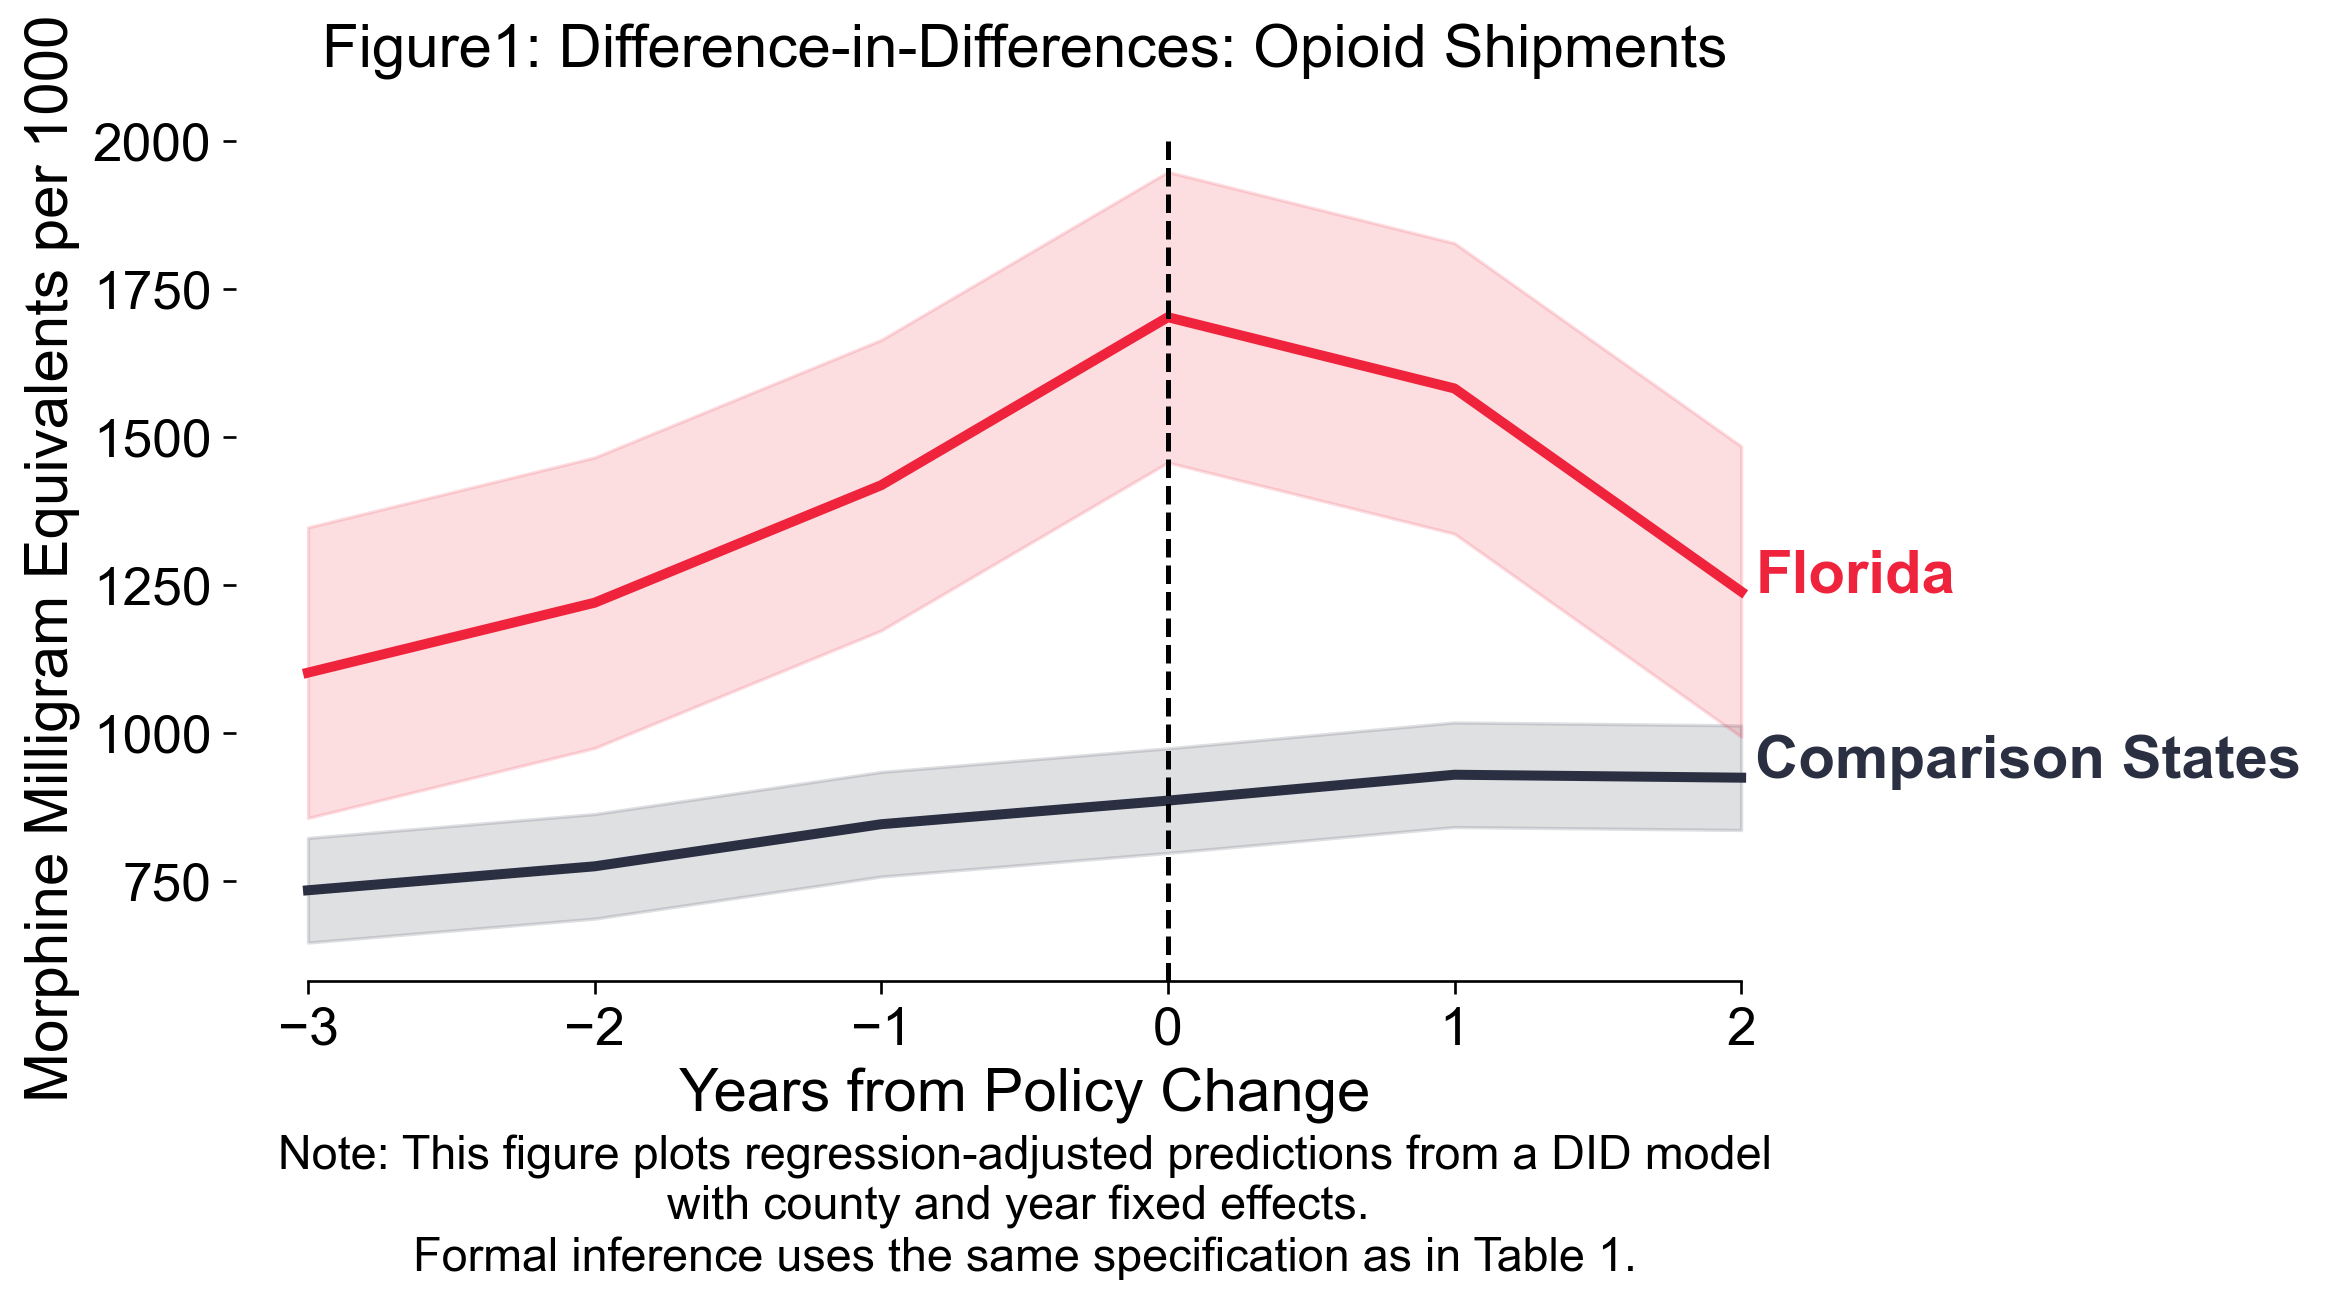

In [17]:
did_df["mme_per_1000"] = did_df["mme_per_capita"] * 1000

did_plot_great(
    df=did_df,
    outcome="mme_per_1000",
    title="Figure1: Difference-in-Differences: Opioid Shipments",
    ylabel="Morphine Milligram Equivalents per 1000",
)

4. DID - Mortality

(<Figure size 1200x720 with 1 Axes>,
 <Axes: title={'center': 'Figure2: Difference-in-Differences: Overdose Mortality'}, xlabel='Years from Policy Change', ylabel='Overdose Deaths per 100k'>)

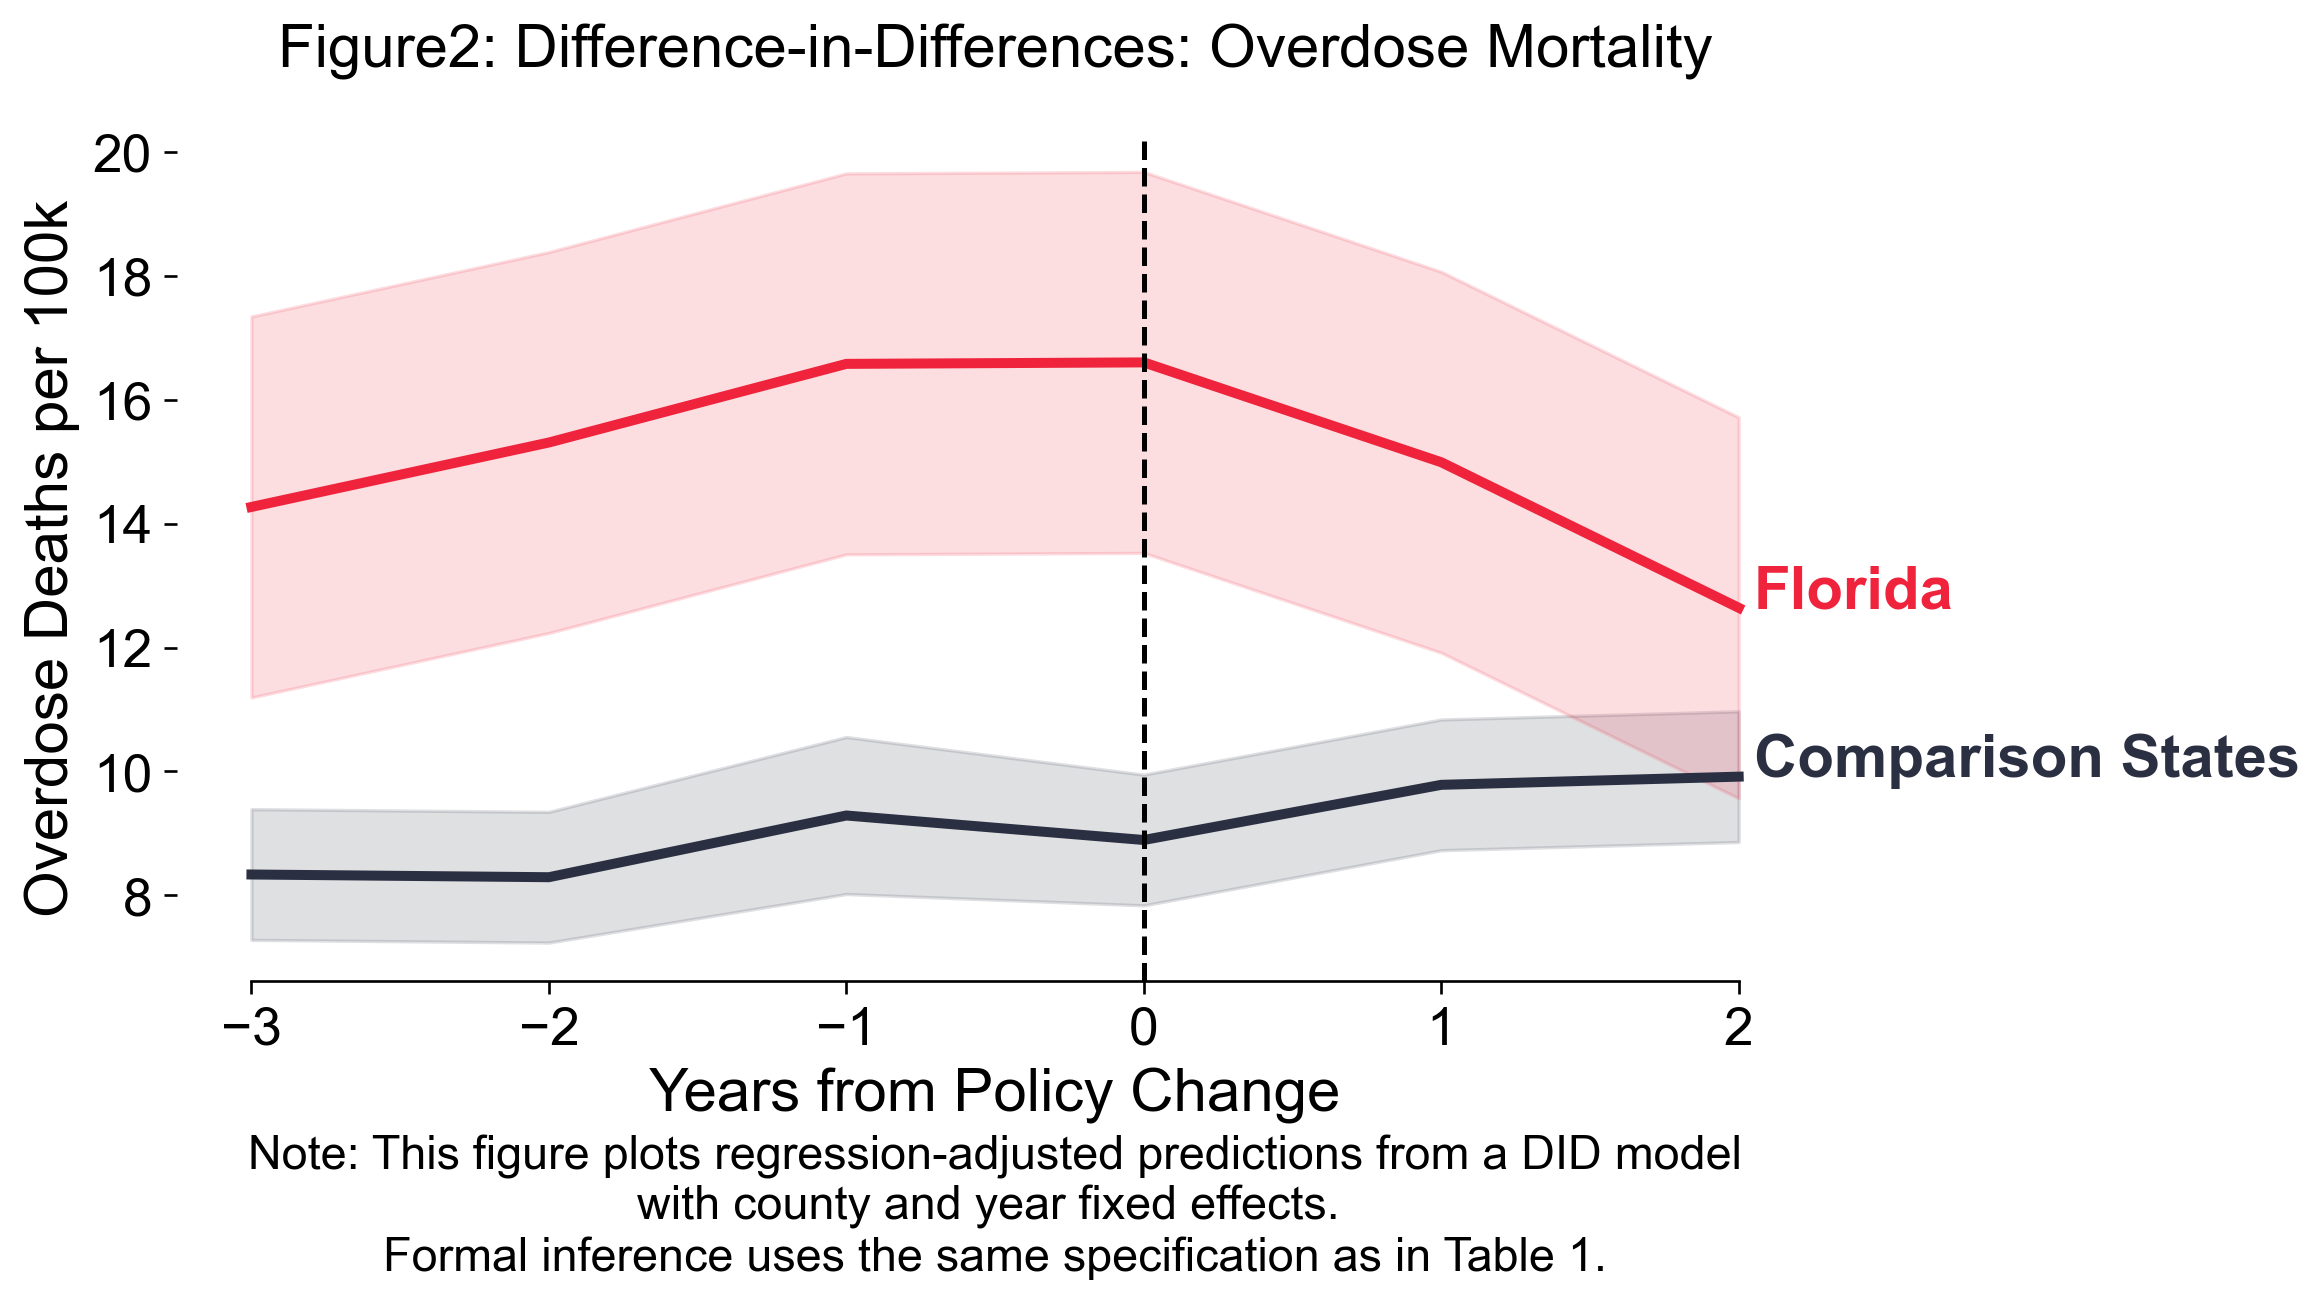

In [18]:
did_plot_great(
    df=did_df,
    outcome="overdose_rate_per_100k",
    title="Figure2: Difference-in-Differences: Overdose Mortality",
    ylabel="Overdose Deaths per 100k",
)

#### Step 6 DID Regression（appendix）

1. Preparation

In [19]:
did_df = did_df.copy()

did_df["county_code"] = did_df["County Code"]
did_df["mme_per_1000"] = did_df["mme_per_capita"] * 1000

import statsmodels.formula.api as smf

In [20]:
did_df = did_df.copy()

# --- Clean controls based on actual columns in df ---

# Age proxy: 18–64 years
did_df["pct_age_25_54"] = (
    did_df["25_to_29_years"]
    + did_df["30_to_34_years"]
    + did_df["35_to_44_years"]
    + did_df["45_to_54_years"]
) / did_df["population"]

# Race structure
did_df["pct_white"] = did_df["White"] / did_df["population"]
did_df["pct_black"] = did_df["Black_or_African_American"] / did_df["population"]

# Education: college-and-above
did_df["pct_college"] = did_df["4_or_more_years_of_college"] / did_df["population"]

# Poverty rate
did_df["poverty_rate"] = did_df["less_than_10,000"] / did_df["population"]

# check control variables
did_df[
    ["pct_age_25_54", "pct_white", "pct_black", "pct_college", "poverty_rate"]
].describe()

,pct_age_25_54,pct_white,pct_black,pct_college,poverty_rate
count,306.000000,306.000000,306.000000,306.000000,306.000000
mean,0.414143,0.702764,0.098506,0.205738,0.021498
std,0.034483,0.123309,0.081700,0.067065,0.007213
min,0.312312,0.428552,0.008535,0.073050,0.008834
25%,0.393560,0.618044,0.031231,0.165224,0.016130
50%,0.417443,0.721066,0.081960,0.200324,0.020220
75%,0.432299,0.803194,0.140287,0.244346,0.026642
max,0.517574,0.917224,0.407090,0.407207,0.042603


In [21]:
did_ship = did_df.dropna(subset=["mme_per_1000"]).copy()
did_mort = did_df.dropna(subset=["overdose_rate_per_100k"]).copy()

2. Shipment DID (no controls)

In [22]:
model_ship = smf.ols(
    formula="""
        mme_per_1000 ~ treat*post
        + C(year) + C(county_code)
    """,
    data=did_ship,
).fit(cov_type="cluster", cov_kwds={"groups": did_ship["county_code"]})

print(model_ship.summary())

                            OLS Regression Results                            
Dep. Variable:           mme_per_1000   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     39.02
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           3.32e-17
Time:                        13:38:06   Log-Likelihood:                -1897.4
No. Observations:                 306   AIC:                             3909.
Df Residuals:                     249   BIC:                             4121.
Df Model:                          56                                         
Covariance Type:              cluster                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/Users/chenqiyu/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 58, but rank is 6
  warnings.warn('covariance of constraints does not have full '


3. Mortality DID (no control)

In [23]:
model_mort = smf.ols(
    formula="""
        overdose_rate_per_100k ~ treat*post
        + C(year) + C(county_code)
    """,
    data=did_mort,
).fit(cov_type="cluster", cov_kwds={"groups": did_mort["county_code"]})

print(model_mort.summary())

                              OLS Regression Results                              
Dep. Variable:     overdose_rate_per_100k   R-squared:                       0.885
Model:                                OLS   Adj. R-squared:                  0.858
Method:                     Least Squares   F-statistic:                     10.89
Date:                    Sun, 07 Dec 2025   Prob (F-statistic):           1.01e-07
Time:                            13:38:07   Log-Likelihood:                -602.52
No. Observations:                     298   AIC:                             1319.
Df Residuals:                         241   BIC:                             1530.
Df Model:                              56                                         
Covariance Type:                  cluster                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

/Users/chenqiyu/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 58, but rank is 6
  warnings.warn('covariance of constraints does not have full '


4. Regression Table

In [24]:
did_df["event_time"] = did_df["year"] - 2010

did_ship = did_df.dropna(subset=["mme_per_1000"]).copy()
did_mort = did_df.dropna(subset=["overdose_rate_per_100k"]).copy()

import statsmodels.formula.api as smf

model_ship = smf.ols(
    "mme_per_1000 ~ treat*post + C(event_time) + C(county_code)",
    data=did_ship,
).fit(cov_type="cluster", cov_kwds={"groups": did_ship["county_code"]})

model_mort = smf.ols(
    "overdose_rate_per_100k ~ treat*post + C(event_time) + C(county_code)",
    data=did_mort,
).fit(cov_type="cluster", cov_kwds={"groups": did_mort["county_code"]})

In [25]:
import pandas as pd

vars_to_keep = ["treat:post", "post", "treat"]


def fmt(model, var):
    b = model.params[var]
    se = model.bse[var]
    return f"{b:.2f} ({se:.2f})"


table_md = pd.DataFrame(
    {
        "Variable": [
            "Treatment × Post",
            "Post (all states)",
            "Treatment (Florida vs. controls)",
        ],
        "(1) MME per 1,000 residents": [fmt(model_ship, v) for v in vars_to_keep],
        "(2) Overdose deaths per 100k": [fmt(model_mort, v) for v in vars_to_keep],
    }
)

table_md

extra_rows = pd.DataFrame(
    {
        "Variable": ["County FE", "Year (event-time) FE", "Observations"],
        "(1) MME per 1,000 residents": ["Yes", "Yes", f"{int(model_ship.nobs)}"],
        "(2) Overdose deaths per 100k": ["Yes", "Yes", f"{int(model_mort.nobs)}"],
    }
)

table_md = pd.concat([table_md, extra_rows], ignore_index=True)

table_md

,Variable,"(1) MME per 1,000 residents",(2) Overdose deaths per 100k
0,Treatment × Post,132.65 (59.14),-1.62 (0.70)
1,Post (all states),153.59 (14.16),1.08 (0.30)
2,Treatment (Florida vs. controls),481.90 (27.60),6.83 (0.33)
3,County FE,Yes,Yes
4,Year (event-time) FE,Yes,Yes
5,Observations,306,298


**Table 1. Difference-in-Differences Regression Results**

| Variable                           | (1) MME per 1,000 residents | (2) Overdose deaths per 100k |
|-----------------------------------|------------------------------|------------------------------|
| **Treatment × Post**              | **132.65 (59.14)**           | **-1.62 (0.70)**             |
| Post (all states)                 | 153.59 (14.16)               | 1.08 (0.30)                  |
| Treatment (Florida vs. controls)  | 481.90 (27.60)               | 6.83 (0.33)                  |
| County FE                         | Yes                          | Yes                          |
| Year (event-time) FE              | Yes                          | Yes                          |
| Observations                      | 306                          | 298                          |

*Notes:* The coefficient on **Treatment × Post** represents the difference-in-differences estimate—the additional change in Florida after the policy relative to the change observed in the comparison states. Positive values indicate increases, and negative values indicate reductions in the respective outcomes.

5. Shipment DID (With Controls)

In [26]:
model_ship_ctrl = smf.ols(
    formula="""
        mme_per_capita ~ treat*post
        + C(year) + C(county_code)
        + population
        + pct_age_25_54
        + pct_white
        + pct_black
        + pct_college
        + poverty_rate
    """,
    data=did_ship,
).fit(cov_type="cluster", cov_kwds={"groups": did_ship["county_code"]})

print(model_ship_ctrl.summary())

                            OLS Regression Results                            
Dep. Variable:         mme_per_capita   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     20.16
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           4.05e-15
Time:                        13:38:07   Log-Likelihood:                 230.34
No. Observations:                 306   AIC:                            -334.7
Df Residuals:                     243   BIC:                            -100.1
Df Model:                          62                                         
Covariance Type:              cluster                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/Users/chenqiyu/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 64, but rank is 12
  warnings.warn('covariance of constraints does not have full '


6. Mortality DID (With Controls)

In [27]:
model_mort_ctrl = smf.ols(
    formula="""
        overdose_rate_per_100k ~ treat*post
        + C(year) + C(county_code)
        + population
        + pct_age_25_54
        + pct_white
        + pct_black
        + pct_college
        + poverty_rate
    """,
    data=did_mort,
).fit(cov_type="cluster", cov_kwds={"groups": did_mort["county_code"]})

print(model_mort_ctrl.summary())

                              OLS Regression Results                              
Dep. Variable:     overdose_rate_per_100k   R-squared:                       0.891
Model:                                OLS   Adj. R-squared:                  0.863
Method:                     Least Squares   F-statistic:                     11.99
Date:                    Sun, 07 Dec 2025   Prob (F-statistic):           6.63e-11
Time:                            13:38:07   Log-Likelihood:                -593.80
No. Observations:                     298   AIC:                             1314.
Df Residuals:                         235   BIC:                             1547.
Df Model:                              62                                         
Covariance Type:                  cluster                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

/Users/chenqiyu/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 64, but rank is 12
  warnings.warn('covariance of constraints does not have full '


7. Compare

In [28]:
did_compare = pd.DataFrame(
    {
        "Outcome": ["MME per Capita", "Overdose Deaths per 100k"],
        "DID_no_controls": [
            model_ship.params["treat:post"],
            model_mort.params["treat:post"],
        ],
        "SE_no_controls": [model_ship.bse["treat:post"], model_mort.bse["treat:post"]],
        "p_no_controls": [
            model_ship.pvalues["treat:post"],
            model_mort.pvalues["treat:post"],
        ],
        "DID_with_controls": [
            model_ship_ctrl.params["treat:post"],
            model_mort_ctrl.params["treat:post"],
        ],
        "SE_with_controls": [
            model_ship_ctrl.bse["treat:post"],
            model_mort_ctrl.bse["treat:post"],
        ],
        "p_with_controls": [
            model_ship_ctrl.pvalues["treat:post"],
            model_mort_ctrl.pvalues["treat:post"],
        ],
    }
)

did_compare

,Outcome,DID_no_controls,SE_no_controls,p_no_controls,DID_with_controls,SE_with_controls,p_with_controls
0,MME per Capita,132.653509,59.140807,0.024896,0.139989,0.041702,0.000788
1,Overdose Deaths per 100k,-1.621297,0.697174,0.020044,-2.010160,0.796606,0.011622


8. DID Table (With and Without Controls)

In [29]:
import pandas as pd
import numpy as np


def fmt(coef, se):
    return f"{coef:.3f}\n({se:.3f})"


# -----------------------------
# 1. combine Shipments Panel
# -----------------------------
ship_noctrl = fmt(model_ship.params["treat:post"], model_ship.bse["treat:post"])

ship_ctrl = fmt(model_ship_ctrl.params["treat:post"], model_ship_ctrl.bse["treat:post"])

# -----------------------------
# 2. combine Mortality Panel
# -----------------------------
mort_noctrl = fmt(model_mort.params["treat:post"], model_mort.bse["treat:post"])

mort_ctrl = fmt(model_mort_ctrl.params["treat:post"], model_mort_ctrl.bse["treat:post"])

# -----------------------------
# 3. paper table
# -----------------------------
reg_table = pd.DataFrame(
    {
        " ": [
            "DID Estimate (treat × post)",
            "",
            "County FE",
            "Year FE",
            "Observations",
        ],
        "Shipments\nNo Controls": [ship_noctrl, "", "Yes", "Yes", model_ship.nobs],
        "Shipments\nWith Controls": [ship_ctrl, "", "Yes", "Yes", model_ship_ctrl.nobs],
        "Mortality\nNo Controls": [mort_noctrl, "", "Yes", "Yes", model_mort.nobs],
        "Mortality\nWith Controls": [mort_ctrl, "", "Yes", "Yes", model_mort_ctrl.nobs],
    }
)

reg_table

,,Shipments\nNo Controls,Shipments\nWith Controls,Mortality\nNo Controls,Mortality\nWith Controls
0,DID Estimate (treat × post),132.654\n(59.141),0.140\n(0.042),-1.621\n(0.697),-2.010\n(0.797)
1,,,,,
2,County FE,Yes,Yes,Yes,Yes
3,Year FE,Yes,Yes,Yes,Yes
4,Observations,306.0,306.0,298.0,298.0
